<a href="https://colab.research.google.com/github/Pini2001/retinopathy/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from PIL import Image
from skimage import data, io, color
import sys
import cv2
from cv2 import cvtColor
from skimage.feature import greycomatrix, greycoprops

In [ ]:
train_csv = '/content/drive/MyDrive/train.csv'
train_images= '/content/drive/MyDrive/train_images.zip'

In [ ]:
with ZipFile('/content/drive/MyDrive/train_images.zip', 'r') as zip_ref:
    # Loop through all files in the zip file
    for filename in zip_ref.namelist():
        # Check if the file is an image (you may want to adjust this based on your image file types)
        if filename.endswith('.png'):
            # Extract the image file to a temporary location if the directory 'DR' doesn't already exist
            if not os.path.exists('DR'):
                os.makedirs('DR')
                zip_ref.extract(filename, path='DR')
            else:
                if not os.path.exists(f'DR/{filename}'):
                    zip_ref.extract(filename, path='DR')

In [ ]:
train = pd.read_csv(train_csv, delimiter=',')
#Creating column
train['labels']= np.where(train['diagnosis'] == 0, 'No', 'Si')
train.dataframeName = 'train.csv'
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')
#len(df.columns)
train.head()

There are 3662 rows and 3 columns in the training set


,id_code,diagnosis,labels
0,000c1434d8d7,2.0,Si
1,001639a390f0,4.0,Si
2,0024cdab0c1e,1.0,Si
3,002c21358ce6,0.0,No
4,005b95c28852,0.0,No


In [ ]:
train['diagnosis'] = train['diagnosis'].astype(int)
print(train['diagnosis'].dtype)

int64


In [ ]:
print(train['diagnosis'].unique())

[               2                4                1                0
                3  325500000000000 8955200000000000 4111800000000000
 3568300000000000 4938100000000000 9544700000000000 2121400000000000
 2143300000000000 4654500000000000]


In [ ]:
print(train['diagnosis'].max())

9544700000000000


In [ ]:
train['id_length'] = train['id_code'].str.len()
print(train['id_length'].unique())


[12  1]


Es probable que los id_codes con longitud 1 sean erróneos

2 longitudes id_code: 12 y 1

In [ ]:
train[train['id_length'] == 1]

,id_code,diagnosis,labels,id_length
493,2,325500000000000,Si,1
791,3,8955200000000000,Si,1
947,4,4111800000000000,Si,1
1207,5,3568300000000000,Si,1
1223,5,4938100000000000,Si,1
1281,5,9544700000000000,Si,1
1617,7,2121400000000000,Si,1
2082,9,2143300000000000,Si,1
2113,9,4654500000000000,Si,1


In [ ]:
train = train[train['id_length'] != 1]
train

,id_code,diagnosis,labels,id_length
0,000c1434d8d7,2,Si,12
1,001639a390f0,4,Si,12
2,0024cdab0c1e,1,Si,12
3,002c21358ce6,0,No,12
4,005b95c28852,0,No,12
...,...,...,...,...
3657,ffa47f6a7bf4,2,Si,12
3658,ffc04fed30e6,0,No,12
3659,ffcf7b45f213,2,Si,12
3660,ffd97f8cd5aa,0,No,12


In [ ]:
print(train['diagnosis'].unique())

[2 4 1 0 3]


In [ ]:
is_diagnosis_whole_number = (train['diagnosis'].astype(int) == train['diagnosis']).all()
if is_diagnosis_whole_number:
    print("All diagnosis values are whole numbers.")
else:
    print("Some diagnosis values are not whole numbers.")


All diagnosis values are whole numbers.


In [ ]:
'''This Function Plots a Bar plot of output Classes Distribution'''
def plot_classes(trainvis):
    df_group = pd.DataFrame(trainvis.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','frecuencia']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis', y='frecuencia', data = df_group, palette = "Blues_d")
    plt.title('Niveles de severidad de la DR')
    plt.show()

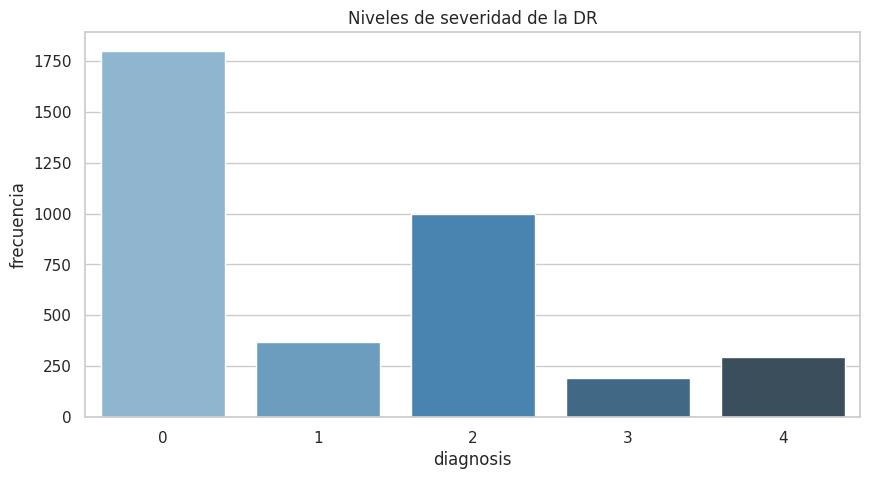

In [ ]:
plot_classes(train)

In [ ]:
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('labels').agg('size').reset_index())
    df_group.columns = ['labels', 'frecuencia']
    sns.set(rc={'figure.figsize': (10, 5)}, style='whitegrid')
    ax = sns.barplot(x='labels', y='frecuencia', data=df_group, hue='labels', dodge=False)
    plt.title('Presencia o no de DR - Frecuencia de Etiquetas')
    for i in ax.containers:
        ax.bar_label(i, label_type='edge')
    ax.set(xlabel='Labels', ylabel='Frecuencia', title='Presencia o no de DR')
    ax.set_xticklabels(ax.get_xticklabels(), ha="center")
    plt.show()


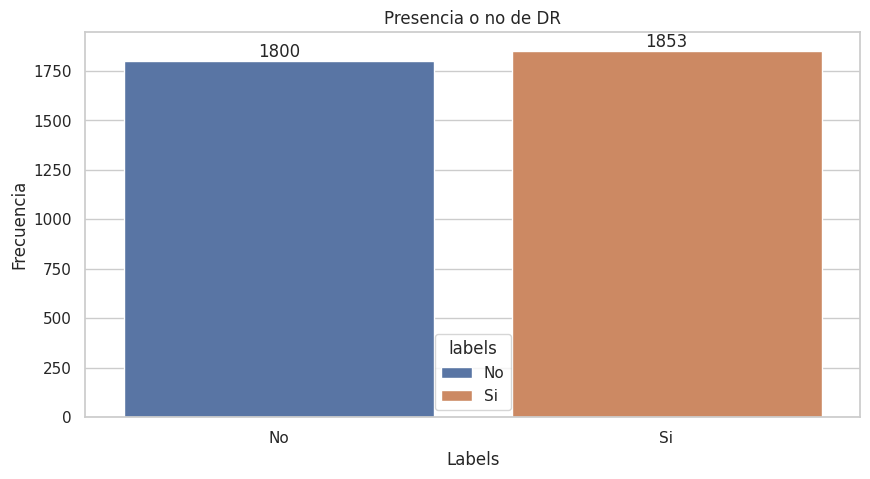

In [ ]:
plot_classes(train)

# DISTINCT SIZES

In [ ]:
directory = "DR"  # directory containing the images
sizes = []  # list to store all image sizes

for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        with Image.open(filepath) as img:
            width, height = img.size
            sizes.append((width, height))

distinct_sizes = set(sizes)  # set of unique image sizes

for size in distinct_sizes:
    print(f"Image size: {size[0]} x {size[1]}")

Image size: 474 x 358
Image size: 2896 x 1944
Image size: 2048 x 1536
Image size: 3216 x 2136
Image size: 2416 x 1736
Image size: 2144 x 1424
Image size: 640 x 480
Image size: 1467 x 1110
Image size: 2146 x 1764
Image size: 3388 x 2588
Image size: 2588 x 1958
Image size: 1476 x 1117
Image size: 1050 x 1050
Image size: 4288 x 2848
Image size: 1504 x 1000
Image size: 819 x 614
Image size: 1844 x 1226


# LUMINOSIDAD

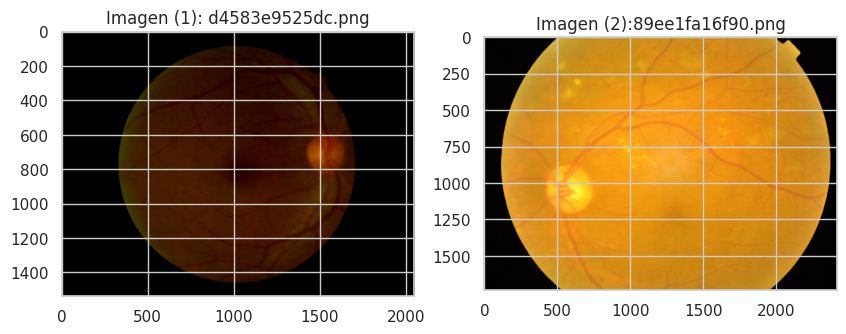

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

directory = "DR"  # directorio que contiene las imágenes
luminosidades = {}  # diccionario para almacenar las luminosidades de las imágenes con su nombre

# Obtener las luminosidades de las imágenes
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    with Image.open(filepath) as img:
        # obtén la luminosidad de la imagen (valor medio de los píxeles)
        luminosidad = np.array(img.convert('L')).mean()
        luminosidades[filename] = luminosidad

# Encontrar la imagen con la luminosidad más baja y la más alta
min_luminosidad = min(luminosidades.values())
max_luminosidad = max(luminosidades.values())

# Mostrar ambas imágenes en una misma fila
fig, axs = plt.subplots(1, 2, figsize=(10,5))
for filename, luminosidad in luminosidades.items():
    with Image.open(os.path.join(directory, filename)) as img:
        # Mostrar la imagen con la luminosidad más baja en la primera subfigura
        if luminosidad == min_luminosidad:
            axs[0].imshow(img)
            axs[0].set_title(f"Imagen (1): {filename}")
        # Mostrar la imagen con la luminosidad más alta en la segunda subfigura
        elif luminosidad == max_luminosidad:
            axs[1].imshow(img)
            axs[1].set_title(f"Imagen (2):{filename}")
plt.show()


# Operador Laplaciano

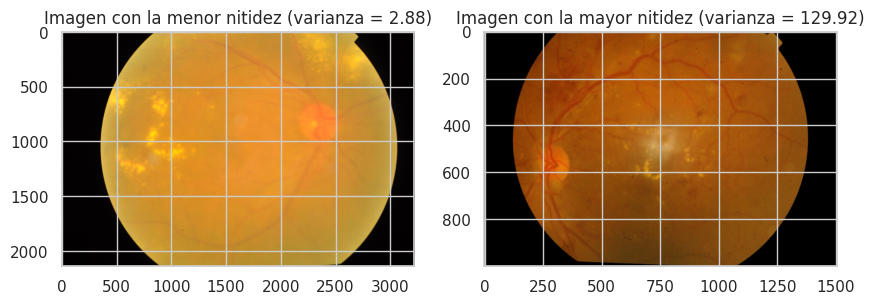

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

directory = "DR"  # directorio que contiene las imágenes
min_image = None  # para almacenar la imagen con la menor varianza
min_var = float('inf')  # para almacenar la varianza mínima encontrada
max_image = None  # para almacenar la imagen con la mayor varianza
max_var = 0  # para almacenar la varianza máxima encontrada

# iterar sobre las imágenes en el directorio
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    with Image.open(filepath) as img:
        # convertir a escala de grises
        gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
        # calcular el operador Laplaciano
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        # calcular la varianza de la respuesta del Laplaciano
        variance = np.var(laplacian)
        # actualizar las imágenes con la menor y mayor varianza encontradas
        if variance < min_var:
            min_image = img
            min_var = variance
        if variance > max_var:
            max_image = img
            max_var = variance

# mostrar ambas imágenes en una misma fila
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(min_image)
axs[0].set_title(f"Imagen con la menor nitidez (varianza = {min_var:.2f})")
axs[1].imshow(max_image)
axs[1].set_title(f"Imagen con la mayor nitidez (varianza = {max_var:.2f})")
plt.show()


# Histograma de imagen

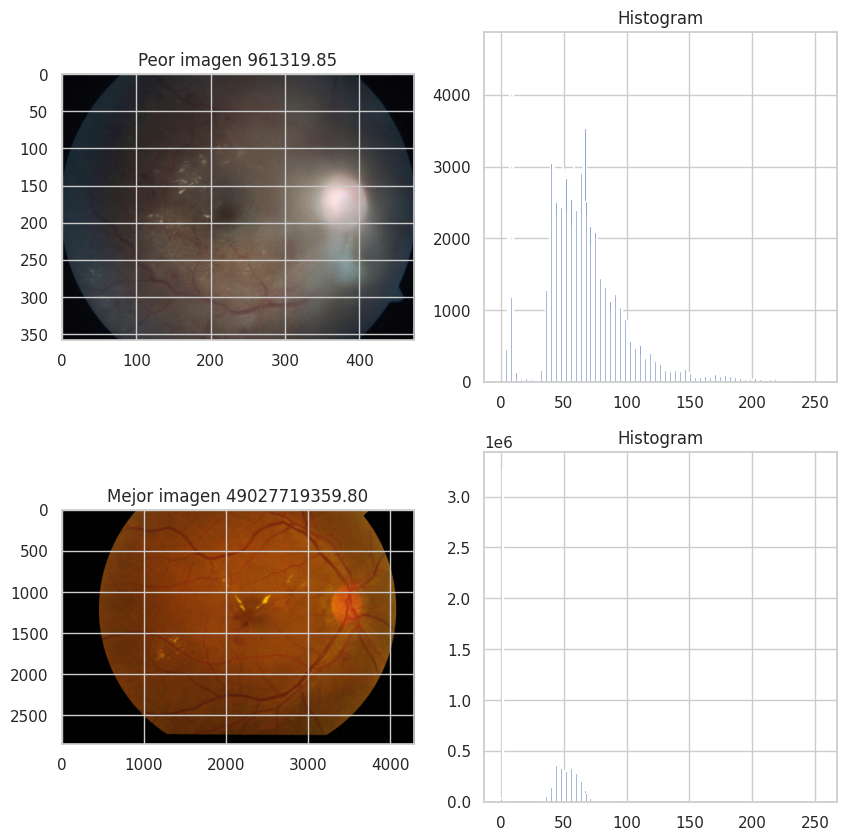

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


directory = "DR"  # directorio que contiene las imágenes
hist_list = []  # lista para almacenar las imágenes con su varianza

# iterar sobre las imágenes en el directorio
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    with Image.open(filepath) as img:
        # Convertir a escala de grises
        gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
        # Calcular el histograma de la imagen
        hist, bins = np.histogram(gray, bins=256, range=(0, 255))
        # Calcular la varianza del histograma
        var = np.var(hist)
        hist_list.append((filename, hist, var))

# Ordenar la lista por varianza del histograma en orden ascendente y descendente
hist_list.sort(key=lambda x: x[2])  # orden ascendente
worst_image, worst_hist, worst_var = hist_list[0]
best_image, best_hist, best_var = hist_list[-1]

# Mostrar los histogramas y las imágenes en la misma fila
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Peor imagen
worst_image, worst_hist, worst_var = hist_list[0]
axs[0, 0].imshow(Image.open(os.path.join(directory, worst_image)))
axs[0, 0].set_title(f"Peor imagen {worst_var:.2f}")
axs[0, 1].bar(bins[:-1], worst_hist, width=1)
axs[0, 1].set_title("Histogram")

# Mejor imagen
best_image, best_hist, best_var = hist_list[-1]
axs[1, 0].imshow(Image.open(os.path.join(directory, best_image)))
axs[1, 0].set_title(f"Mejor imagen {best_var:.2f}")
axs[1, 1].bar(bins[:-1], best_hist, width=1)
axs[1, 1].set_title("Histogram")

plt.show()



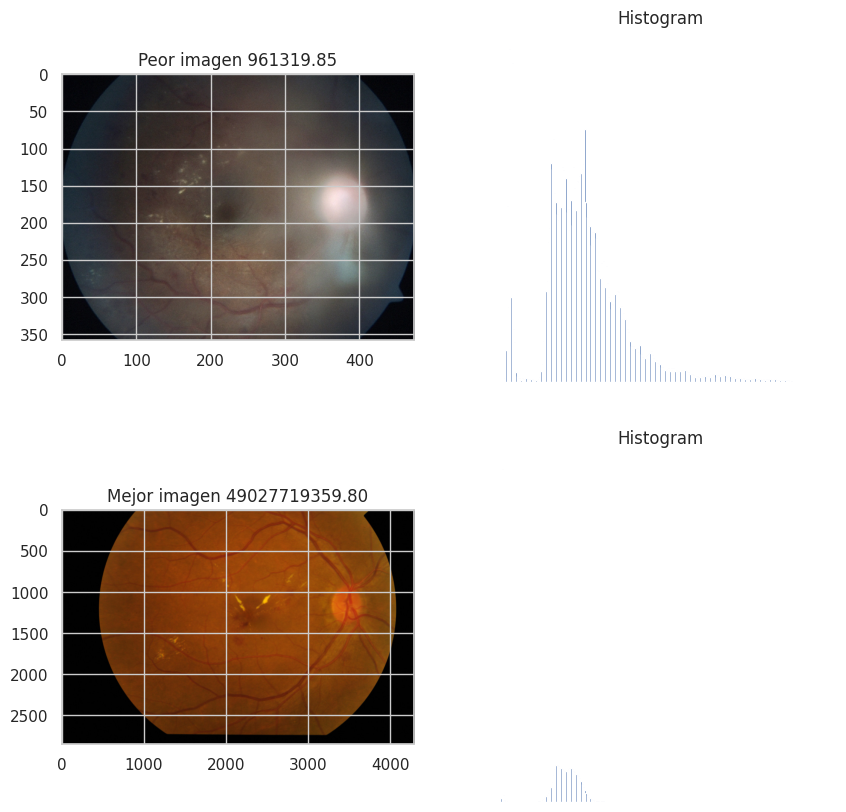

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image


directory = "DR"  # directorio que contiene las imágenes
hist_list = []  # lista para almacenar las imágenes con su varianza

# iterar sobre las imágenes en el directorio
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    with Image.open(filepath) as img:
        # Convertir a escala de grises
        gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
        # Calcular el histograma de la imagen
        hist, bins = np.histogram(gray, bins=256, range=(0, 255))
        # Calcular la varianza del histograma
        var = np.var(hist)
        hist_list.append((filename, hist, var))

# Ordenar la lista por varianza del histograma en orden ascendente y descendente
hist_list.sort(key=lambda x: x[2])  # orden ascendente
worst_image, worst_hist, worst_var = hist_list[0]
best_image, best_hist, best_var = hist_list[-1]

# Mostrar los histogramas y las imágenes en la misma fila
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Peor imagen
worst_image, worst_hist, worst_var = hist_list[0]
axs[0, 0].imshow(Image.open(os.path.join(directory, worst_image)), cmap='gray')
axs[0, 0].set_title(f"Peor imagen {worst_var:.2f}")
axs[0, 1].bar(bins[:-1], worst_hist, width=1)
axs[0, 1].set_title("Histogram")
axs[0, 1].axis('off')

# Mejor imagen
best_image, best_hist, best_var = hist_list[-1]
axs[1, 0].imshow(Image.open(os.path.join(directory, best_image)), cmap='gray')
axs[1, 0].set_title(f"Mejor imagen {best_var:.2f}")
axs[1, 1].bar(bins[:-1], best_hist, width=1)
axs[1, 1].set_title("Histogram")
axs[1, 1].axis('off')

plt.show()
